### Import packages

In [1]:
import warnings
from ml_utils import *
warnings.filterwarnings("ignore")

### Read and prepare data

In [2]:
df = pd.read_csv("data_houses.csv")
cols = ["OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "FullBath", "YearBuilt", "YearRemodAdd", "MSSubClass", "MoSold"]
df = df[["Id"]+cols+["SalePrice"]]
df.set_index("Id", inplace=True)
df['Y'] = df['SalePrice']
df.drop("SalePrice", axis=1, inplace=True)
df.head(35)


,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,MSSubClass,MoSold,Y
Id,,,,,,,,,,,
1,7,1710,2,548,856,2,2003,2003,60,2,208500
2,6,1262,2,460,1262,2,1976,1976,20,5,181500
3,7,1786,2,608,920,2,2001,2002,60,9,223500
4,7,1717,3,642,756,1,1915,1970,70,2,140000
5,8,2198,3,836,1145,2,2000,2000,60,12,250000
6,5,1362,2,480,796,1,1993,1995,50,10,143000
7,8,1694,2,636,1686,2,2004,2005,20,8,307000
8,7,2090,2,484,1107,2,1973,1973,60,11,200000
9,7,1774,2,468,952,2,1931,1950,50,4,129900


## Data Analysis

- y: SalePrice
- info: OverallQual, YearBuilt, YearRemodAdd, MSSubClass, MoSold
- inside: GrLivArea, FullBath
- extra: GarageCars, GarageArea, TotalBsmtSF


### Remove outliers for target variable

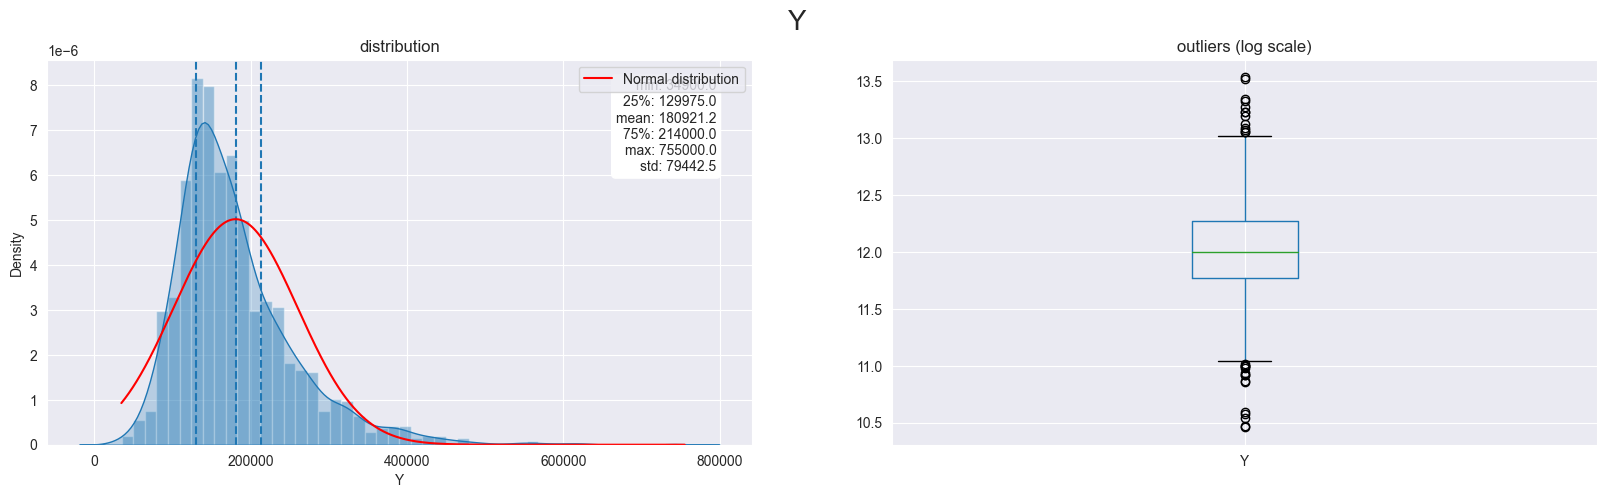

In [3]:
freqdist_plot(df, "Y", box_logscale=True, figsize=(20,5), with_normal=True)

По ЗБЧ, среднее арифметическое $mean = \frac{\sum_{i=1}^{n} x_i}{n} = 180921.2 \approx EX$ при достаточно больших n.

Имеется не симметричность относительно матожидания. Однако это можно исправить, навесив логарифм на фичу. Таким образом расстояние между далеких объктами станет меньше, а между близкими - больше. Как видим - теперь таргетная переменная хорошо описывается нормальным распределением с параметрами mean=12.02$\approx EX$, std=0.4$\approx \sqrt{DX}$:

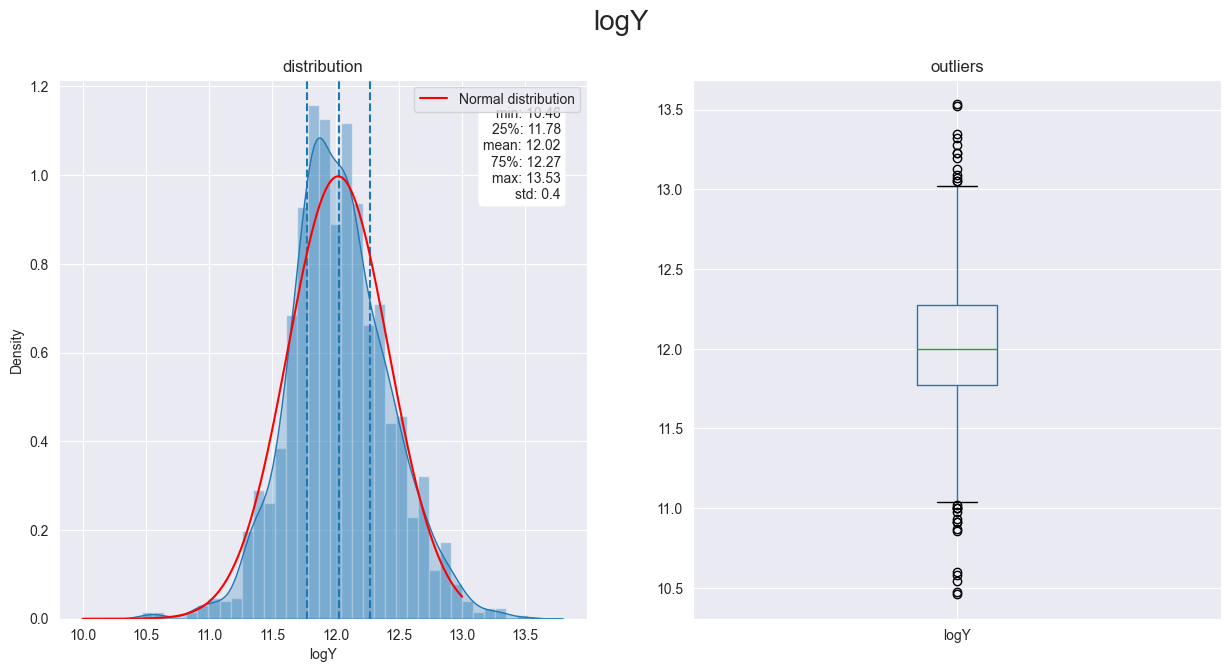

In [4]:
df['logY'] = np.log(df['Y'])
freqdist_plot(df, "logY", figsize=(15,7), with_normal=True)


Теперь воспользуемся правилом трех сигм, которое гласит, что 99.7% данных находится в промежутке $(EX - 3\sqrt{DX}, EX + 3\sqrt{DX})$. Таким образом мы избавимся от выбросов, которые могут в дальнейшем отрицательно повлиять на качество обучаемой модели, потому что будут не подходить под ожидаемое обобщение, которые составит модель.

In [5]:
from scipy.stats import zscore

df = df[(-3 < zscore(df['logY'])) & (zscore(df['logY']) < 3)]

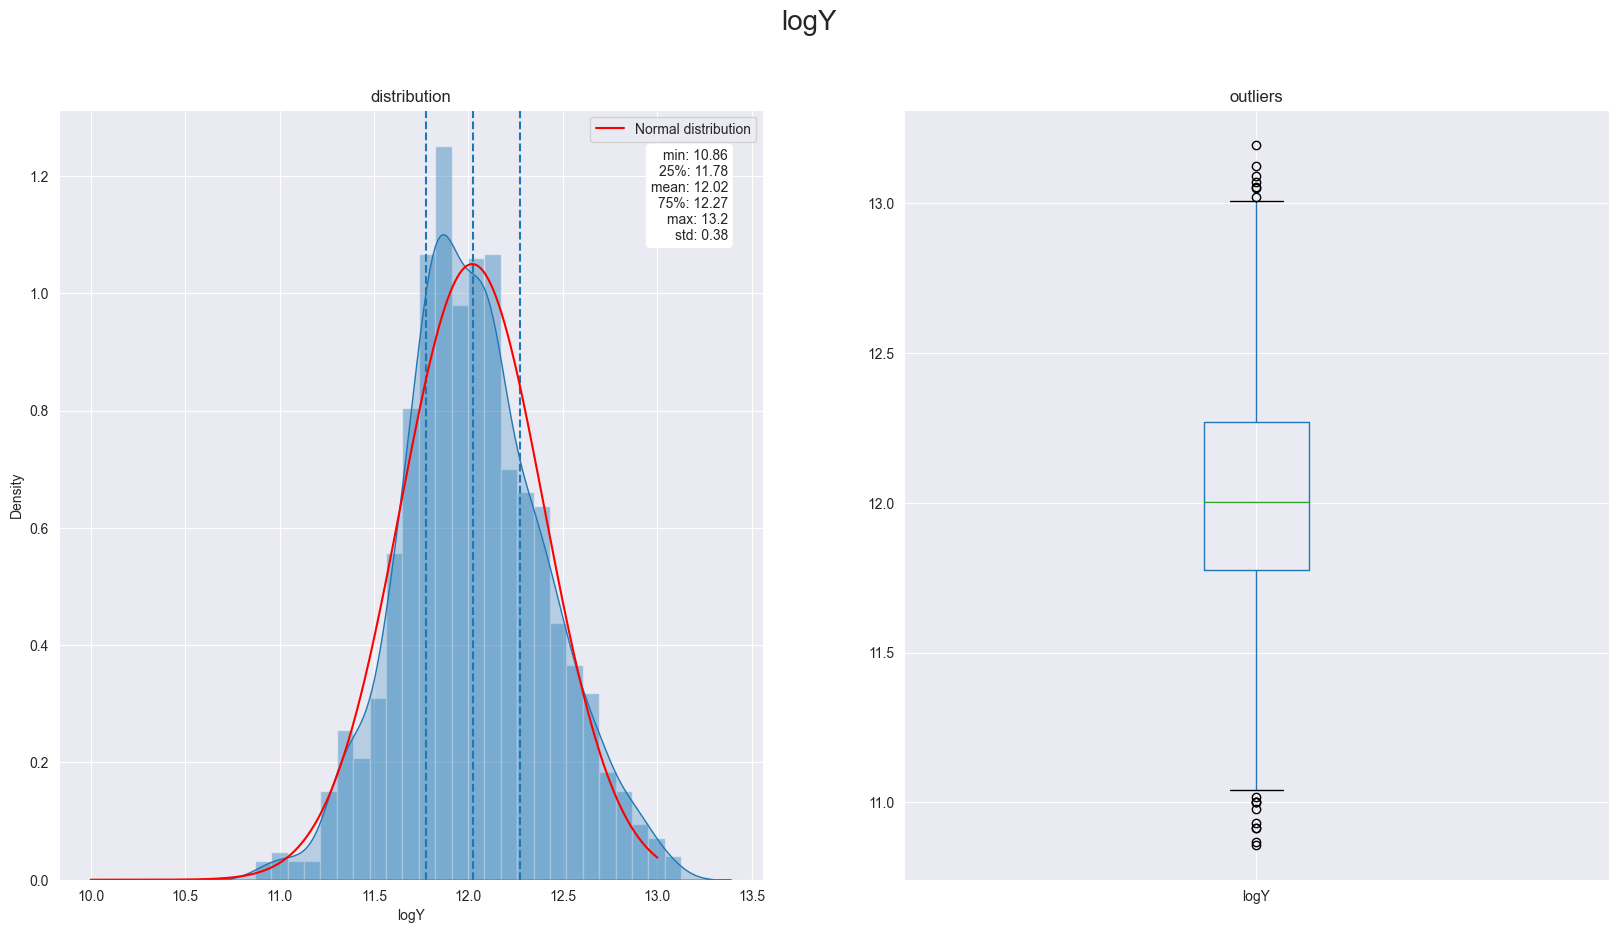

In [6]:
freqdist_plot(df, "logY", figsize=(20,10), with_normal=True)

Далее будем рассматривать только logY в качестве таргетной, так как именно она имеет распределение приближенное к нормальному. Заметим, что исходная переменная легко восстанавливается, если применить np.exp() к logY (биекция).

In [7]:
df.drop("Y", axis=1, inplace=True)

### Проанализируем значимость каждой фичи для таргетной переменной

In [8]:
features = []   # сюда складываем значимые фичи

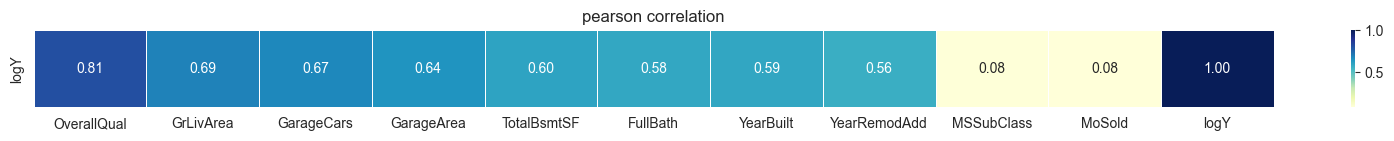

In [9]:
corr = corr_matrix(df, method="pearson", negative=False, lst_filters=["logY"], figsize=(20,1))

##### OverallQual

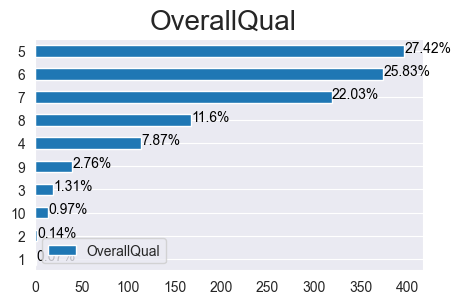

In [10]:
freqdist_plot(df, "OverallQual", figsize=(5,3))


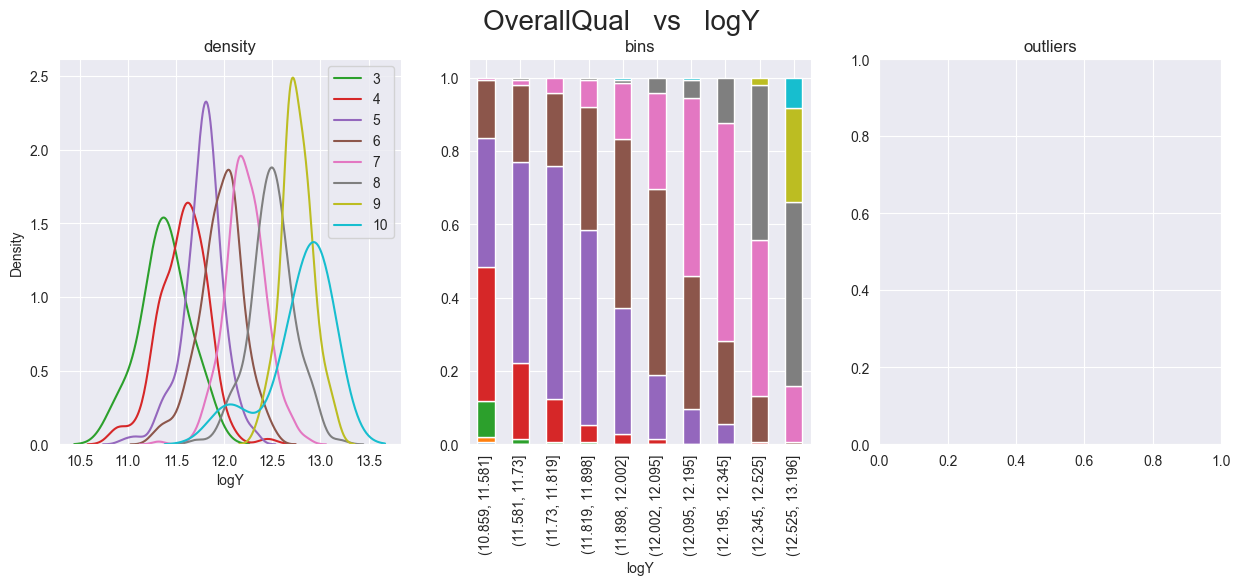

In [11]:
bivariate_plot(df, x="OverallQual", y="logY", figsize=(15,5))

OverallQual is Predictive: the higher the quality the higher the price.

In [12]:
features.append("OverallQual")

##### YearBuilt

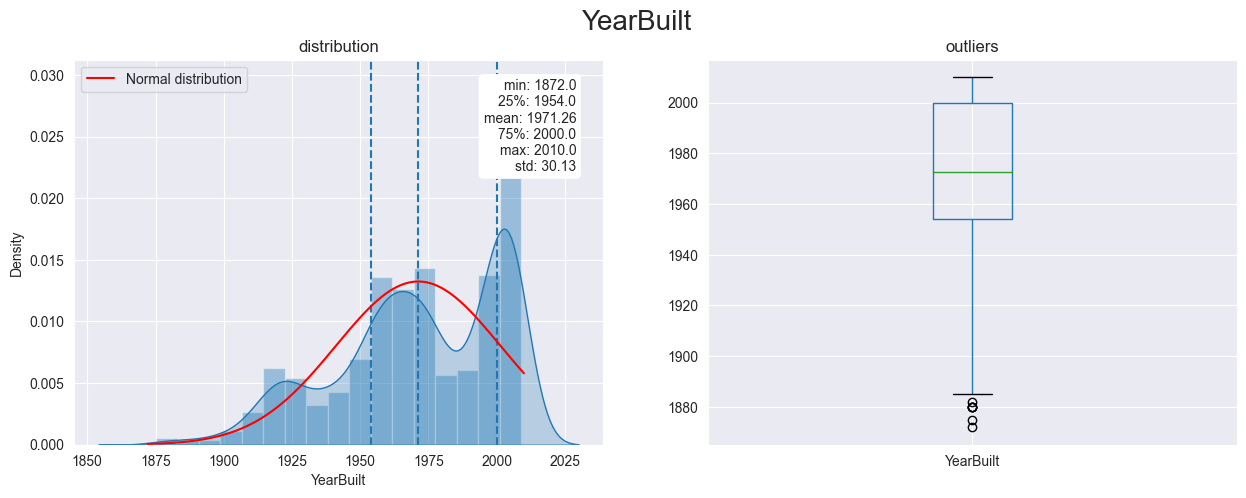

In [13]:
freqdist_plot(df, "YearBuilt", figsize=(15, 5), with_normal=True)

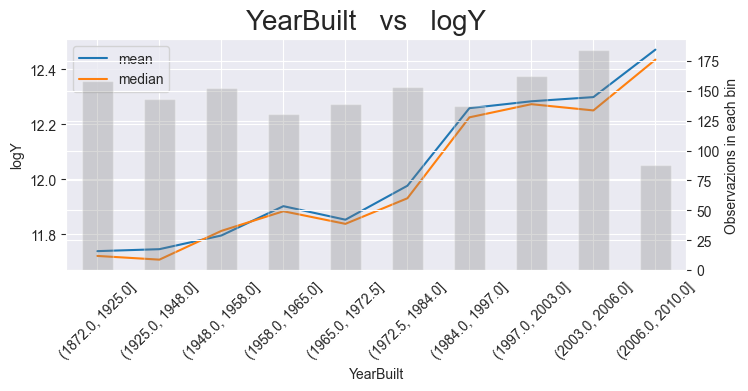

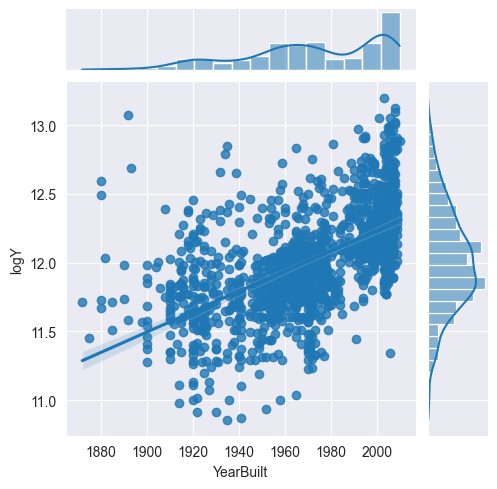

In [14]:
bivariate_plot(df, x="YearBuilt", y="logY", figsize=(8, 3))


YearBuilt is Predictive: the more recent the construction the higher the price.

In [15]:
features.append("YearBuilt")

##### YearRemodAdd

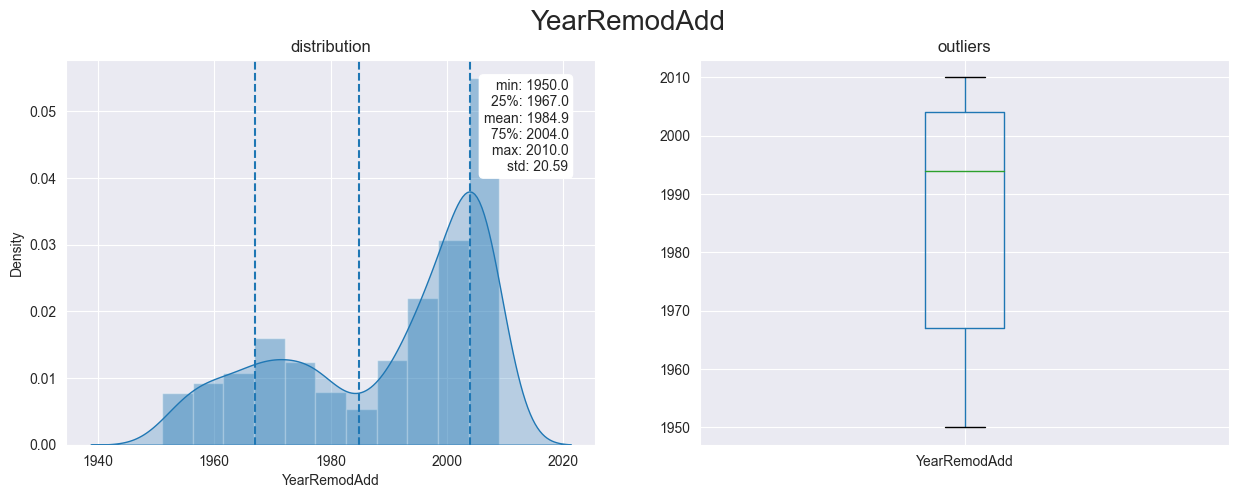

In [16]:
freqdist_plot(df, "YearRemodAdd", figsize=(15, 5), with_normal=False)

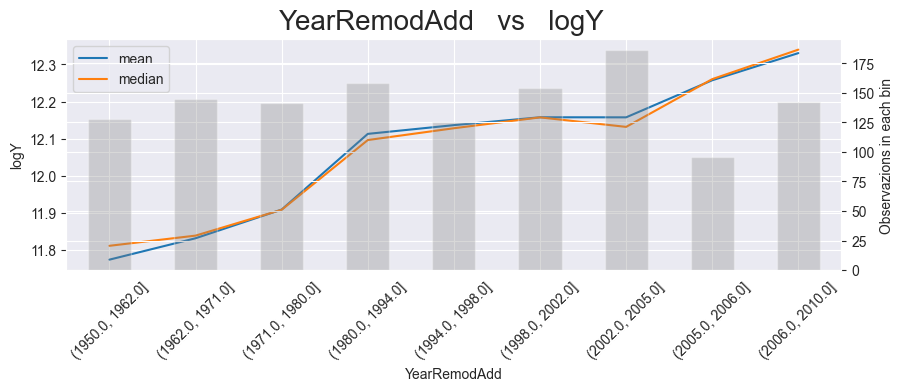

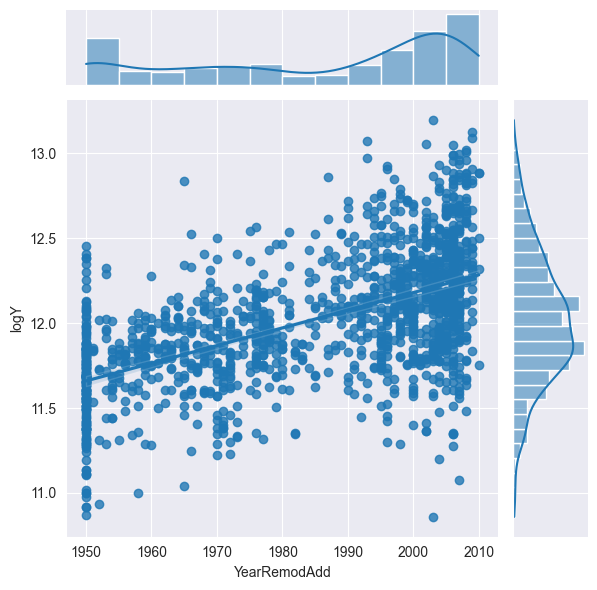

In [17]:
bivariate_plot(df, x="YearRemodAdd", y="logY", figsize=(10,3))

YearRemodAdd is Predictive: the more recent the renovation the higher the price

In [18]:
features.append("YearRemodAdd")

##### MSSubClass

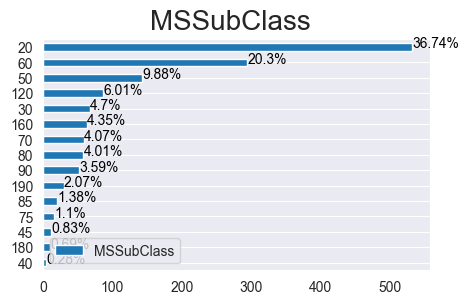

In [19]:
freqdist_plot(df, "MSSubClass", figsize=(5,3))


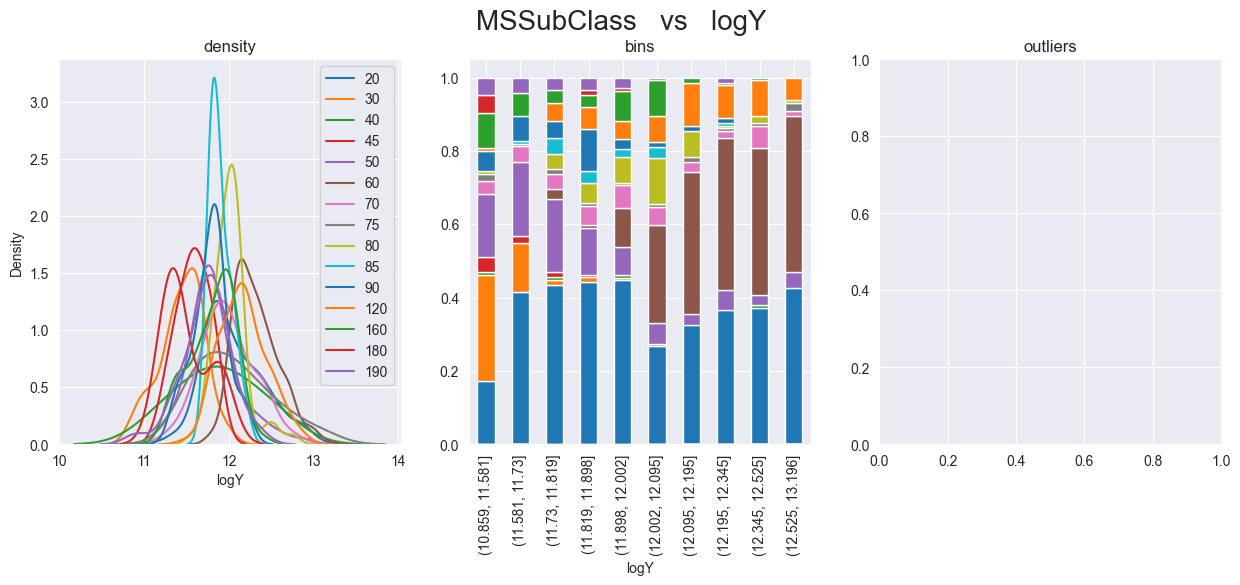

In [20]:
# Выберем отсюда 3 кластера на основе левого графика.
bivariate_plot(df, x="MSSubClass", y="logY", figsize=(15,5))


In [21]:
MSSubClass_clusters = {"min": [30, 45, 180], "max": [60, 120], "mean": []}
df = add_feature_clusters(df, "MSSubClass", dic_clusters_mapping=MSSubClass_clusters, dropx=False)
df[["MSSubClass", "MSSubClass_cluster", "logY"]].head(5)


,MSSubClass,MSSubClass_cluster,logY
Id,,,
1,60,max,12.247694
2,20,mean,12.109011
3,60,max,12.317167
4,70,mean,11.849398
5,60,max,12.429216


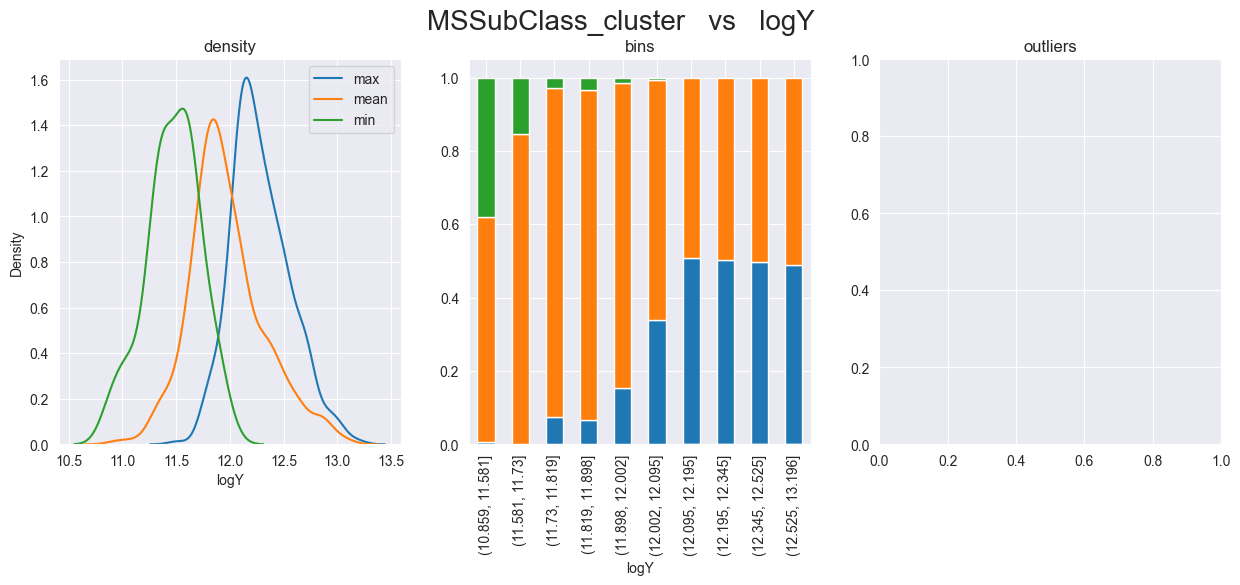

In [22]:
bivariate_plot(df, x="MSSubClass_cluster", y="logY", figsize=(15,5))

MSSubClass_cluster is Predictive: different lot classes (clusters) lead to different house prices.

In [23]:
features.append("MSSubClass_cluster")

##### MoSold

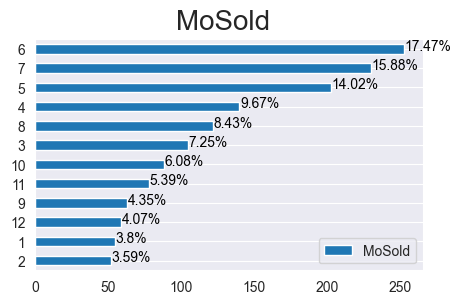

In [24]:
freqdist_plot(df, "MoSold", figsize=(5,3))

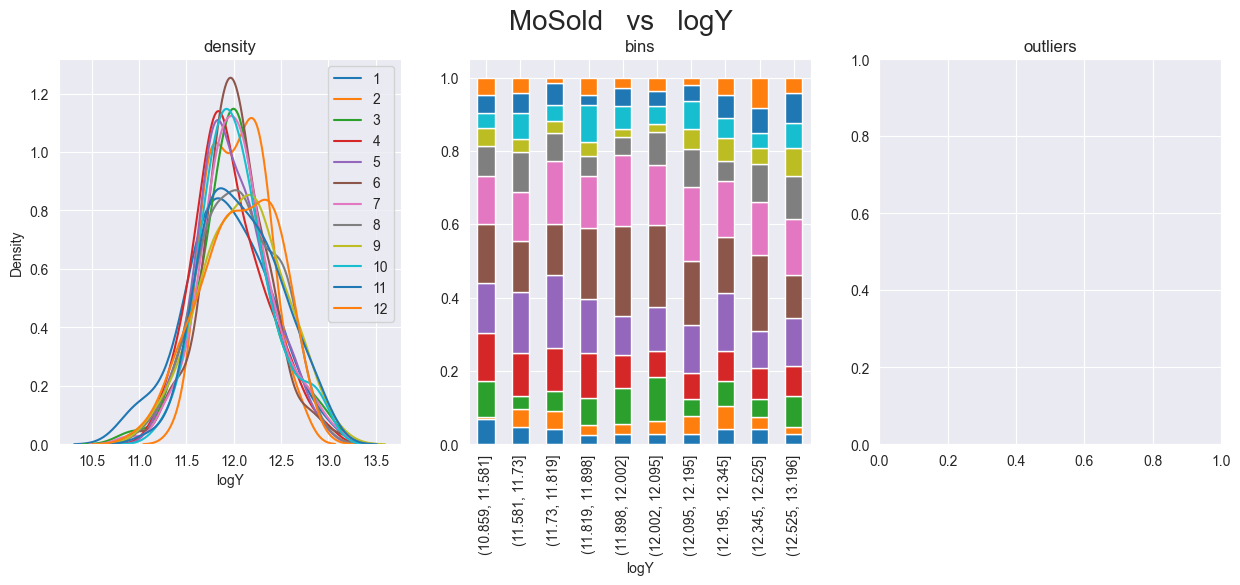

In [25]:
bivariate_plot(df, x="MoSold", y="logY", figsize=(15,5))

In [26]:
MoSold_clusters = {"min": [], "max": [8, 9, 10, 11, 12]}
df = add_feature_clusters(df, "MoSold", dic_clusters_mapping=MoSold_clusters, dropx=False)
df[["MoSold", "MoSold_cluster", "logY"]].head(5)

,MoSold,MoSold_cluster,logY
Id,,,
1,2,min,12.247694
2,5,min,12.109011
3,9,max,12.317167
4,2,min,11.849398
5,12,max,12.429216


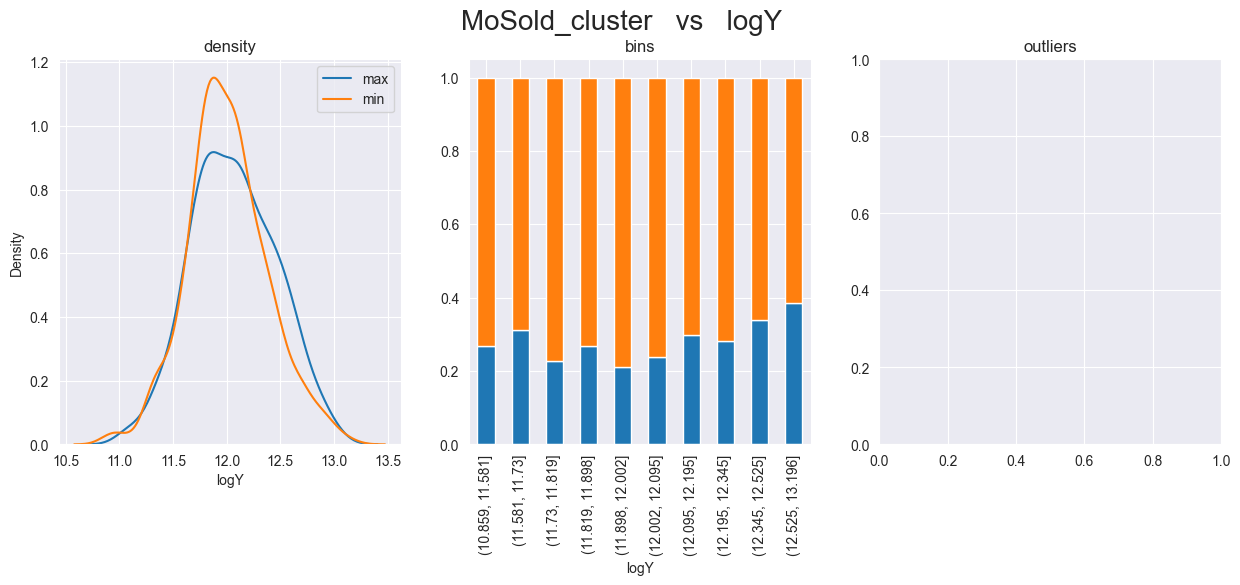

In [27]:
bivariate_plot(df, x="MoSold_cluster", y="logY", figsize=(15,5))

Одна плотность выше другой на одном и том же интервале. Это значит, что больше случаев покупки весной-летом, чем осенью-зимой. Однако частота покупки никак не влияет в данном случае на цену. Поэтому считаем этот признак лишним.

##### GrLivArea

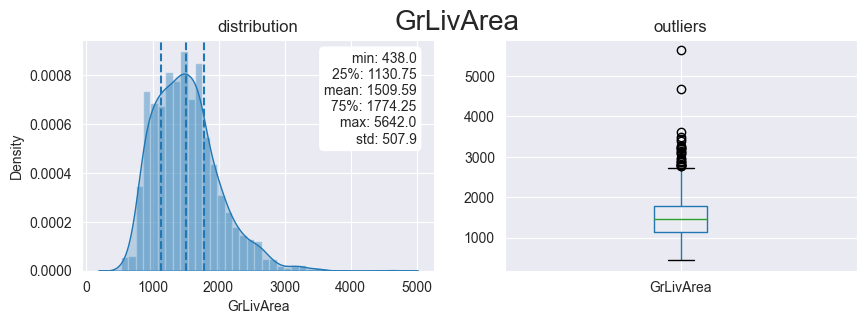

In [28]:
freqdist_plot(df, "GrLivArea", figsize=(10,3))

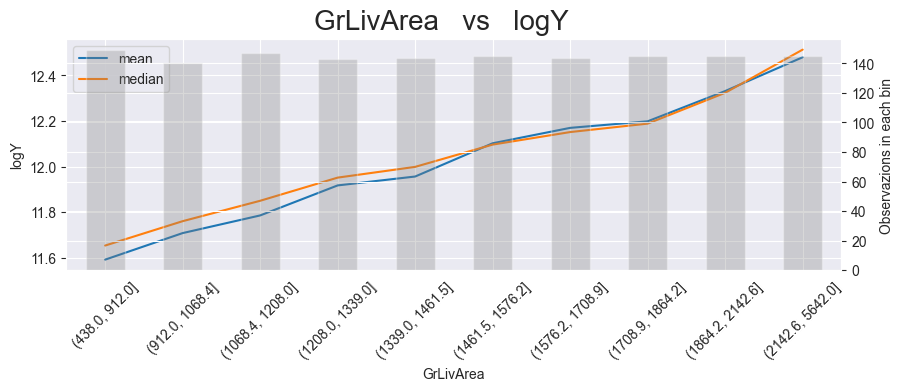

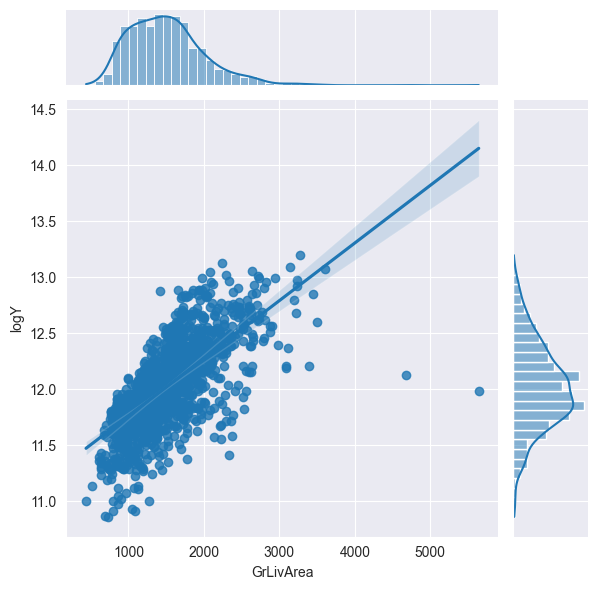

In [29]:
bivariate_plot(df, x="GrLivArea", y="logY", figsize=(10,3))

GrLivArea is Predctive: the larger the living area the higher the price.

In [30]:
features.append("GrLivArea")

##### FullBath

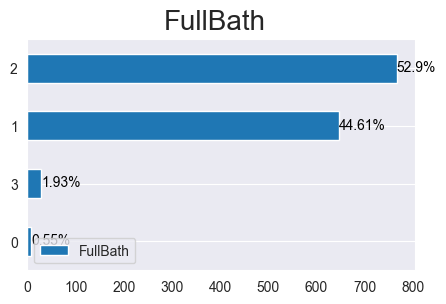

In [31]:
freqdist_plot(df, "FullBath", figsize=(5,3))

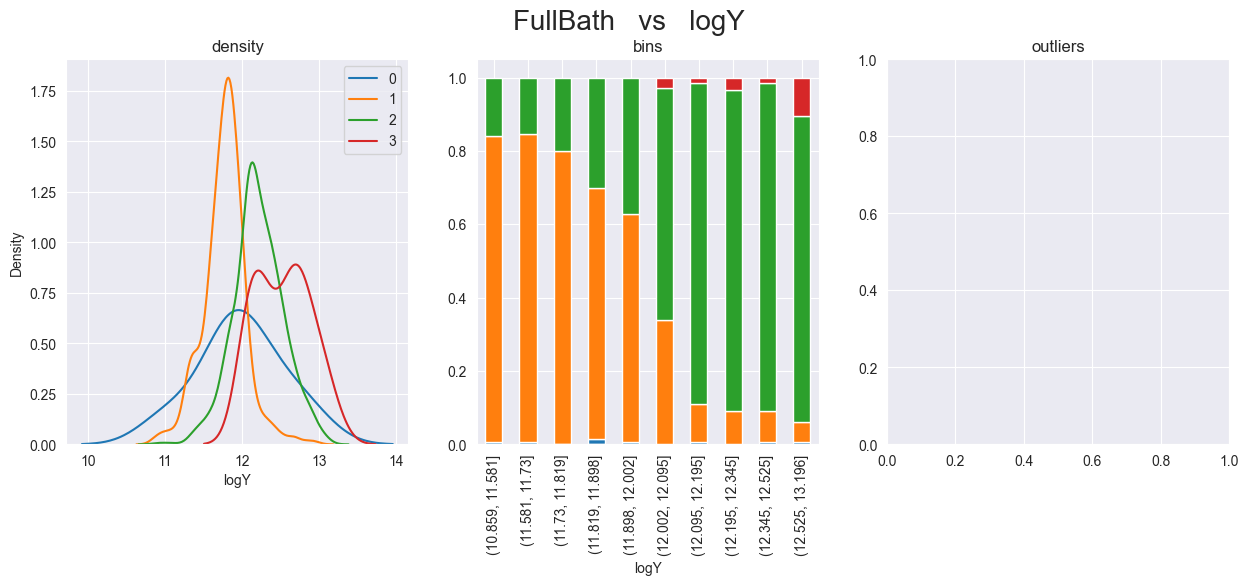

In [32]:
bivariate_plot(df, x="FullBath", y="logY", figsize=(15,5))

Неясно значима ли фича.

In [33]:
from scipy.stats import pearsonr
corr, p = pearsonr(df['FullBath'], df['logY'])
corr

0.5824270297415209

Фичи коррелируемы.

FullBath is Predctive: the more bathrooms there are the higher the price.


In [34]:
features.append("FullBath")

##### GarageCars

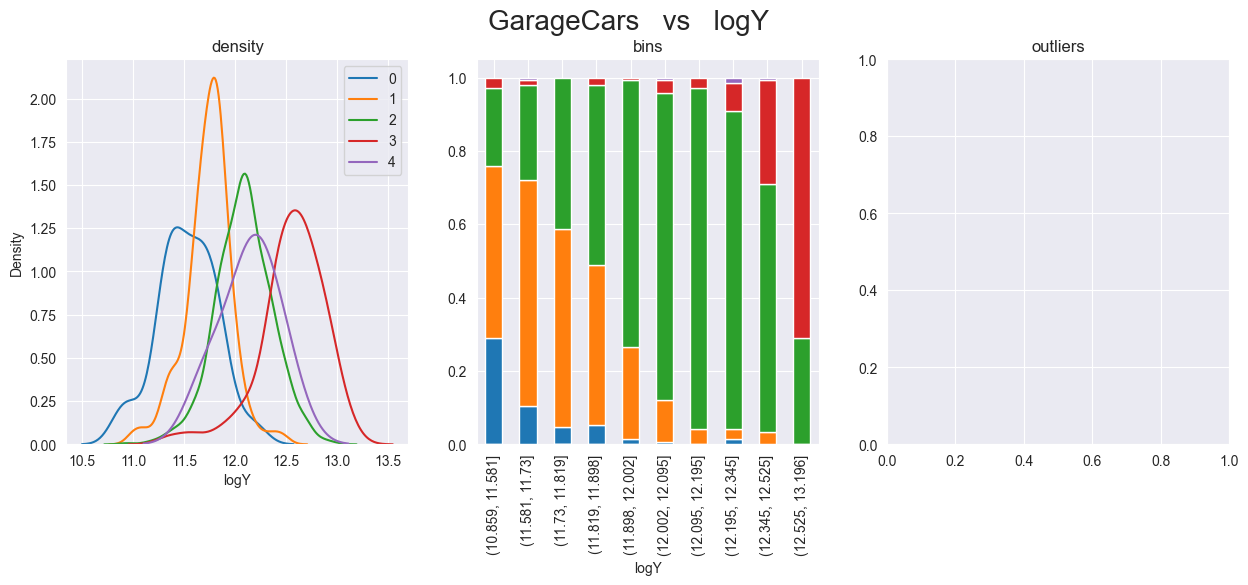

In [35]:
bivariate_plot(df, x="GarageCars", y="logY", figsize=(15,5))

GarageCars is Predictive: the larger is the garage (in cars) the higher is the house price.

In [36]:
features.append("GarageCars")

##### GarageArea

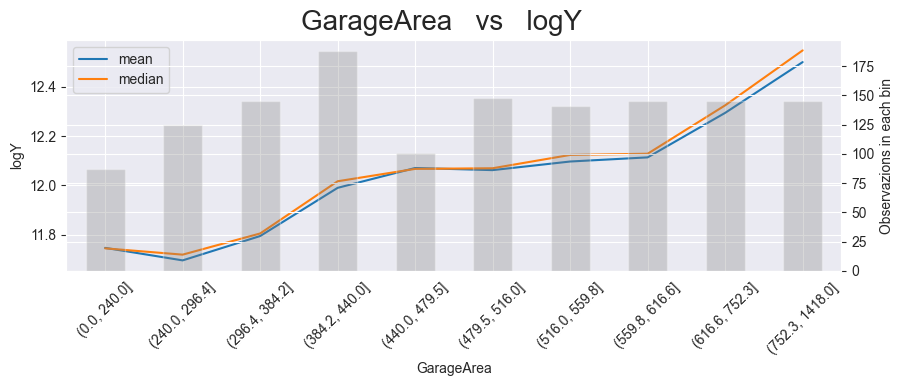

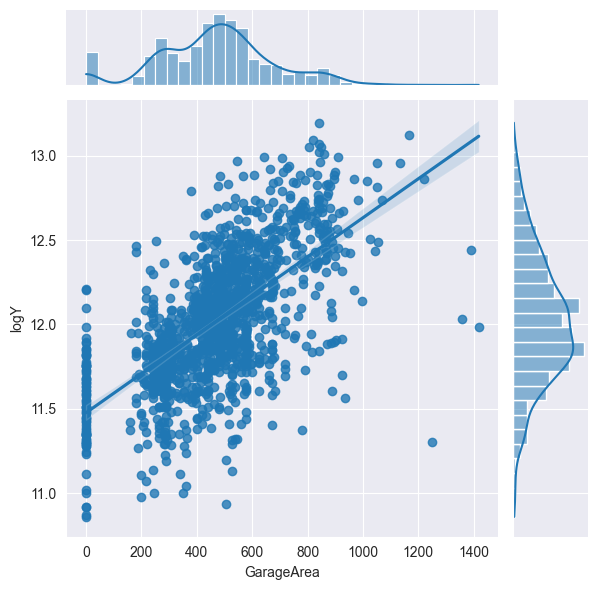

In [37]:
bivariate_plot(df, x="GarageArea", y="logY", figsize=(10,3))


GarageArea is Predictive: the larger is the garage (is sqrfeet) the higher is the house price

In [38]:
features.append("GarageArea")

##### TotalBsmtSF

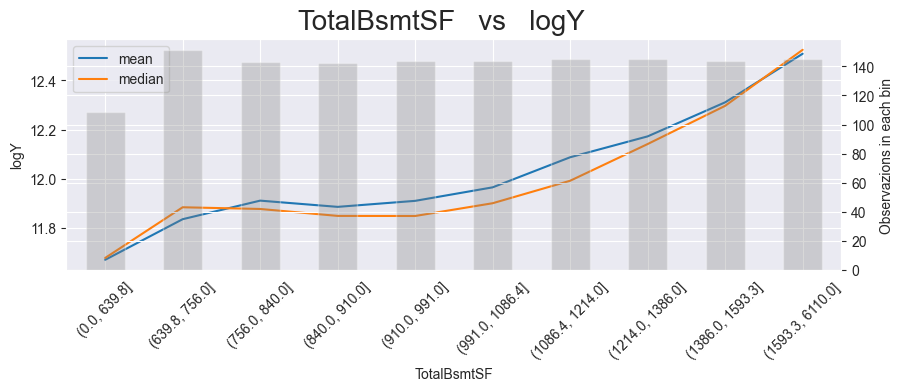

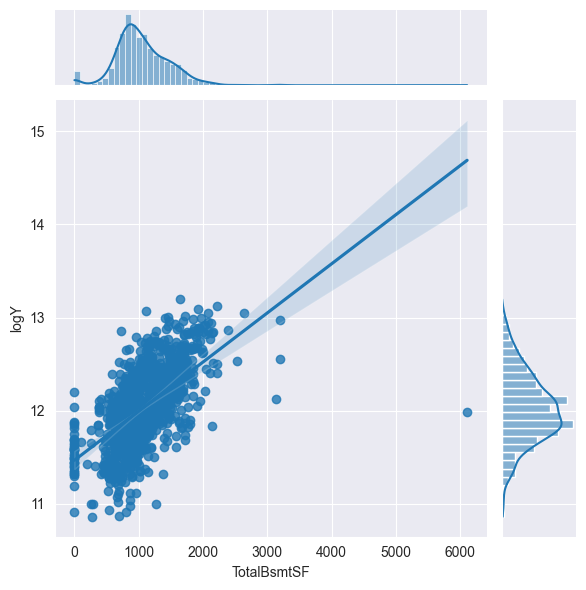

In [39]:
bivariate_plot(df, x="TotalBsmtSF", y="logY", figsize=(10,3))

TotalBsmtSF, is Predictive: the larger is the basement the higher is the house price.

In [40]:
features.append("TotalBsmtSF")

##### Summary

In [41]:
df = df[features+["logY"]]
df.head()

,OverallQual,YearBuilt,YearRemodAdd,MSSubClass_cluster,GrLivArea,FullBath,GarageCars,GarageArea,TotalBsmtSF,logY
Id,,,,,,,,,,
1,7,2003,2003,max,1710,2,2,548,856,12.247694
2,6,1976,1976,mean,1262,2,2,460,1262,12.109011
3,7,2001,2002,max,1786,2,2,608,920,12.317167
4,7,1915,1970,mean,1717,1,3,642,756,11.849398
5,8,2000,2000,max,2198,2,3,836,1145,12.429216


### Train/test split
Предварительно разделим выборку на обучающую и тестовую

In [42]:
check = data_preprocessing(df, y="logY", task="regression")

--- check missing ---
   OK: No missing
--- check categorical data ---
--- split train/test ---
   OK: step skipped
--- scaling ---
   OK: step skipped


In [43]:
df_train, df_test = dtf_partitioning(df, y="logY", test_size=0.3, shuffle=False)


X_train shape: (1013, 9) | X_test shape: (435, 9)
y_train mean: 12.03 | y_test mean: 12.01
10 features: ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MSSubClass_cluster', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea', 'TotalBsmtSF']


### Categorical encoding

In [44]:
df_train = add_dummies(df_train, x="MSSubClass_cluster", dropx=True)


   MSSubClass_cluster  MSSubClass_cluster_mean  MSSubClass_cluster_min
Id                                                                    
1                 max                        0                       0
2                mean                        1                       0
3                 max                        0                       0
4                mean                        1                       0
5                 max                        0                       0


since the other catogories indicate all quantities, there's no need to encode them.

### Scaling

Выполним scaling путем применения StandardScaler:
$z = \frac{x - mean}{std}$, для больших n по ЦПТ $mean = EX, std = DX$



In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
scalerX = StandardScaler()
scalerY = StandardScaler()

In [47]:
df_train, scalerX, scalerY = scaling(df_train, y="logY", scalerX=scalerX, scalerY=scalerY, task="regression")


In [48]:
df_train.head()

,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,GarageCars,GarageArea,TotalBsmtSF,MSSubClass_cluster_mean,MSSubClass_cluster_min,logY
Id,,,,,,,,,,,
1,0.649445,1.045804,0.869769,0.412766,0.793710,0.323560,0.367877,-0.487998,-1.410036,-0.257519,0.569406
2,-0.091420,0.142964,-0.458189,-0.489122,0.793710,0.323560,-0.058202,0.494073,0.709202,-0.257519,0.208379
3,0.649445,0.978927,0.820585,0.565765,0.793710,0.323560,0.658386,-0.333189,-1.410036,-0.257519,0.750260
4,0.649445,-1.896787,-0.753291,0.426858,-1.041971,1.683587,0.823008,-0.729888,0.709202,-0.257519,-0.467458
5,1.390309,0.945489,0.722218,1.395180,0.793710,1.683587,1.762319,0.211062,-1.410036,-0.257519,1.041952


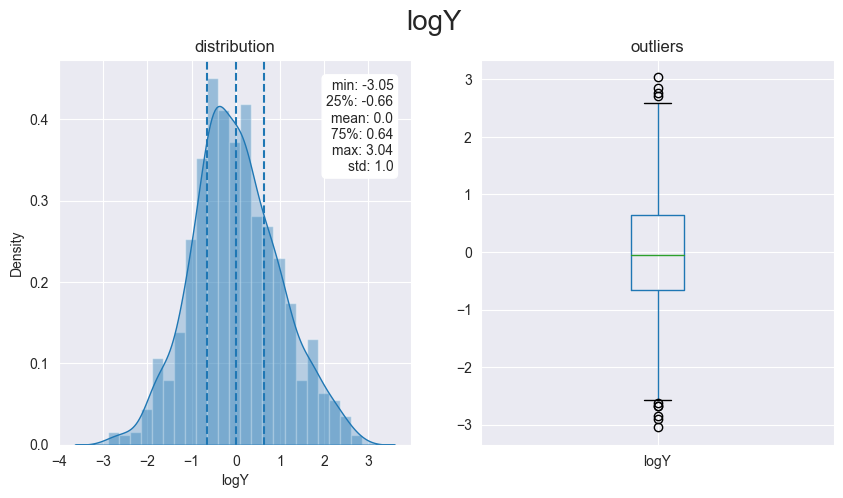

In [49]:
freqdist_plot(df_train, 'logY')

Shape: (1013, 11)
-----------------
OverallQual --> Type:cat | Nas: 0(0%) | Categories: 10
YearBuilt --> Type:num | Nas: 0(0%) | Min-Max: (-3)-(1)
YearRemodAdd --> Type:num | Nas: 0(0%) | Min-Max: (-1)-(1)
GrLivArea --> Type:num | Nas: 0(0%) | Min-Max: (-1)-(6)
FullBath --> Type:cat | Nas: 0(0%) | Categories: 4
GarageCars --> Type:cat | Nas: 0(0%) | Categories: 5
GarageArea --> Type:num | Nas: 0(0%) | Min-Max: (-2)-(4)
TotalBsmtSF --> Type:num | Nas: 0(0%) | Min-Max: (-2)-(5)
MSSubClass_cluster_mean --> Type:cat | Nas: 0(0%) | Categories: 2
MSSubClass_cluster_min --> Type:cat | Nas: 0(0%) | Categories: 2
logY --> Type:num | Nas: 0(0%) | Min-Max: (-3)-(3)


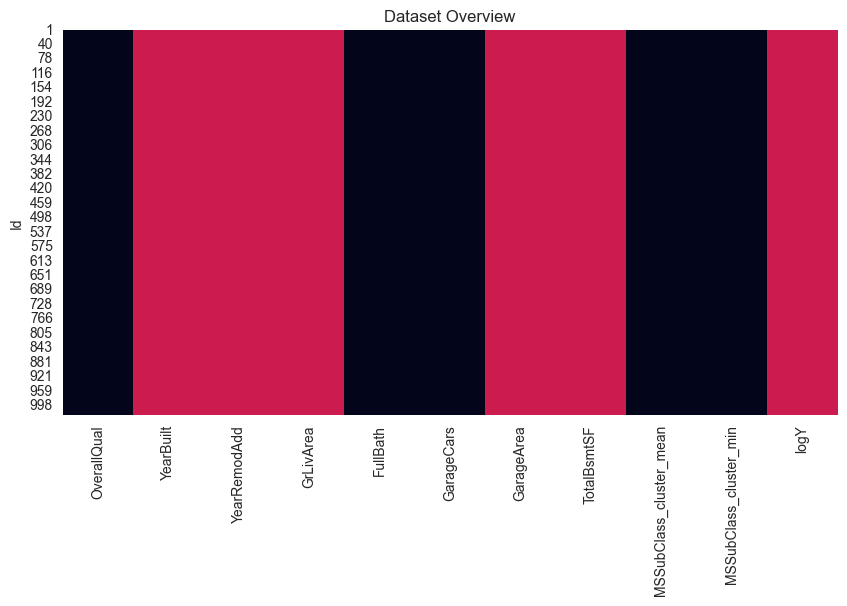

 Categerocial   Numerical   NaN 


In [50]:
dtf_overview(df_train)

### Test data preprocessing

In [51]:
## Categorical
df_test = add_dummies(df_test, x="MSSubClass_cluster", dropx=True)

     MSSubClass_cluster  MSSubClass_cluster_mean  MSSubClass_cluster_min
Id                                                                      
1023               mean                        1                       0
1024                max                        0                       0
1025               mean                        1                       0
1026               mean                        1                       0
1027               mean                        1                       0


In [52]:
df_test = df_test[df_train.columns]
df_test.head()

,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,GarageCars,GarageArea,TotalBsmtSF,MSSubClass_cluster_mean,MSSubClass_cluster_min,logY
Id,,,,,,,,,,,
1023,5,1930,1950,1248,1,1,160,912,1,0,11.373663
1024,7,2005,2006,1504,2,2,437,1346,0,0,12.160029
1025,8,1976,1976,2898,2,2,665,1565,1,0,12.567237
1026,5,1972,1972,882,1,2,461,882,1,0,11.630709
1027,5,1960,1960,1264,1,2,461,1268,1,0,12.028739


In [53]:
## Scaling
df_test, _, _ = scaling(df_test, y="logY", scalerX=scalerX, scalerY=scalerY, fitted=True, task="regression")


In [54]:
df_test

,OverallQual,YearBuilt,YearRemodAdd,GrLivArea,FullBath,GarageCars,GarageArea,TotalBsmtSF,MSSubClass_cluster_mean,MSSubClass_cluster_min,logY
Id,,,,,,,,,,,
1023,-0.832284,-1.395209,-1.736964,-0.517306,-1.041971,-1.036467,-1.510746,-0.352540,0.709202,-0.257519,11.373663
1024,0.649445,1.112681,1.017320,-0.001942,0.793710,0.323560,-0.169564,0.697260,-1.410036,-0.257519,12.160029
1025,1.390309,0.142964,-0.458189,2.804380,0.793710,0.323560,0.934369,1.226998,0.709202,-0.257519,12.567237
1026,-0.832284,0.009210,-0.654924,-1.254117,-1.041971,0.323560,-0.053360,-0.425107,0.709202,-0.257519,11.630709
1027,-0.832284,-0.392053,-1.245128,-0.485096,-1.041971,0.323560,-0.053360,0.508586,0.709202,-0.257519,12.028739
...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.091420,0.912050,0.722218,0.285938,0.793710,0.323560,-0.058202,-0.253365,-1.410036,-0.257519,12.072541
1457,-0.091420,0.209841,0.132014,1.143537,0.793710,0.323560,0.135470,1.171363,0.709202,-0.257519,12.254863
1458,0.649445,-1.027385,1.017320,1.681046,0.793710,-1.036467,-1.065299,0.227995,0.709202,-0.257519,12.493130


### Корреляции и feature selection

Построим матрицу корреляций Пирсона:
$\rho_{X,Y} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}}$


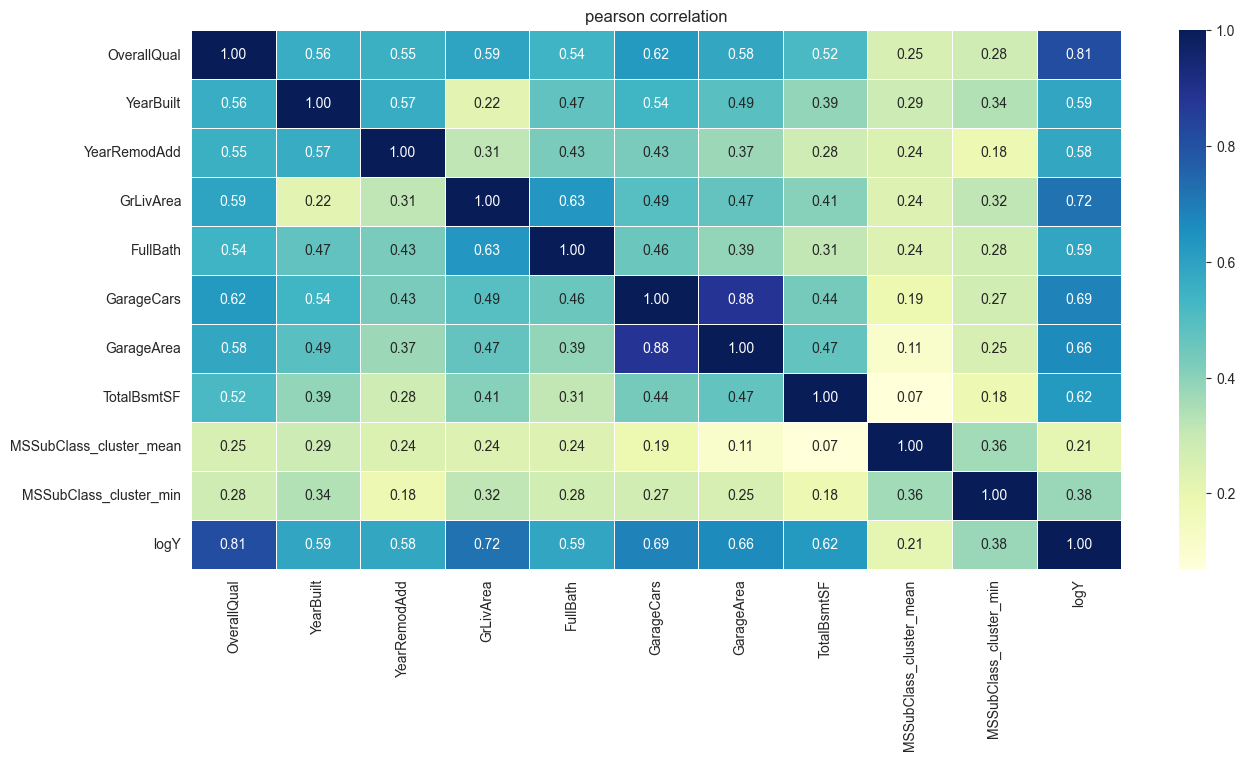

In [55]:
corr = corr_matrix(df_train, method="pearson", negative=False, annotation=True, figsize=(15,7))

Выбираем следующие фичи: OverallQual, GrLivArea, GarageCars, TotalBsmtSF, YearBuilt

In [56]:
# -> selection
X_selected = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageCars']

### Model training

In [57]:
X_train = df_train[X_selected].values
y_train = df_train["logY"].values

In [58]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()


In [59]:
model.fit(X_train, y_train)

LinearRegression()

In [60]:
X_test = df_test[X_selected].values
y_test = df_test["logY"].values

In [61]:
model, predicted = fit_ml_regr(model, X_train, y_train, X_test, scalerY)

R2 (explained variance): 0.73
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.01
Mean Absolute Error (Σ|y-pred|/n): 0
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 0
Max Error: -2


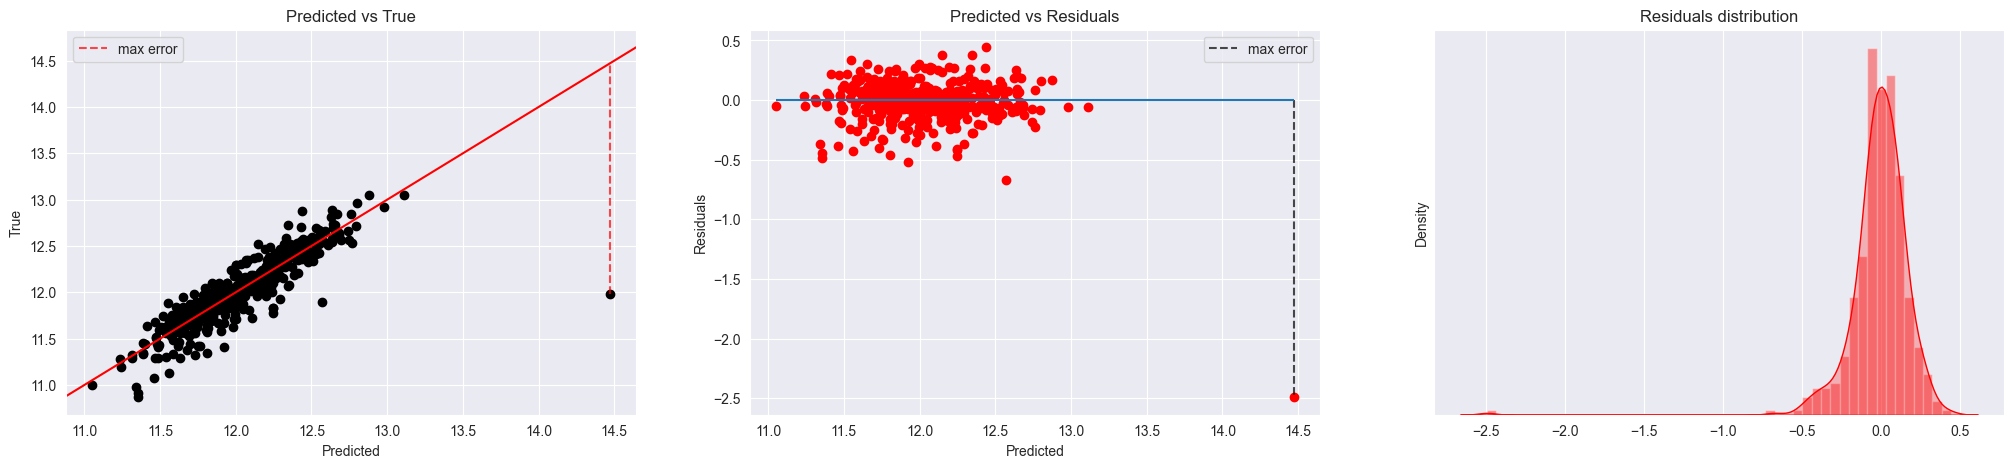

In [62]:
evaluate_regr_model(y_test, predicted, figsize=(25,5))

R2 (explained variance): -0.7
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.11
Mean Absolute Error (Σ|y-pred|/n): 23,510
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 89,155
Max Error: -1,770,946


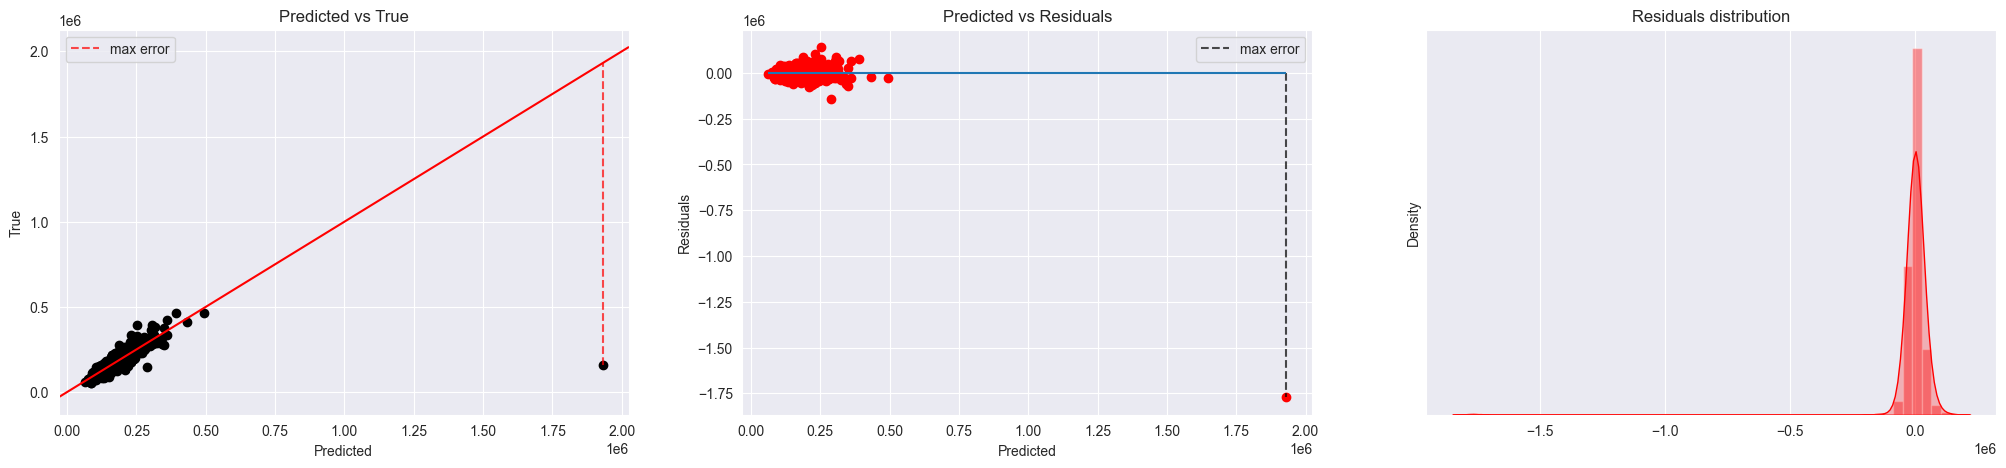

In [63]:
evaluate_regr_model(np.exp(np.array(y_test)), np.exp(np.array(predicted)), figsize=(25,5))
